In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier

# Load main dataset
train = pd.read_csv("./home-credit-default-risk/application_train.csv")

print("Initial Train shape:", train.shape)

# Identify all categorical columns
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# One-hot encode all categorical columns
train = pd.get_dummies(train, columns=cat_cols, dummy_na=True)

print("After one-hot encoding, Train shape:", train.shape)

Initial Train shape: (307511, 122)
After one-hot encoding, Train shape: (307511, 262)


In [2]:
# Bureau and Bureau Balance
bureau = pd.read_csv("./home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("./home-credit-default-risk/bureau_balance.csv")

# Aggregate bureau_balance
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'STATUS': ['nunique']
})
bureau_balance_agg.columns = ['BUREAU_BAL_' + '_'.join(col).upper() for col in bureau_balance_agg.columns]

# Merge bureau_balance aggregates with bureau
bureau = bureau.merge(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
del bureau_balance, bureau_balance_agg
gc.collect()

# Aggregate bureau data by SK_ID_CURR
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
    'BUREAU_BAL_MONTHS_BALANCE_MIN': ['min', 'mean'],
    'BUREAU_BAL_MONTHS_BALANCE_MAX': ['max', 'mean'],
    'BUREAU_BAL_MONTHS_BALANCE_MEAN': ['mean'],
    'BUREAU_BAL_STATUS_NUNIQUE': ['mean']
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]

# Merge bureau aggregates with train
train = train.merge(bureau_agg, how='left', on='SK_ID_CURR')
del bureau, bureau_agg
gc.collect()

# Previous Applications
prev = pd.read_csv("./home-credit-default-risk/previous_application.csv")
prev_agg = prev.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean'],
    'AMT_CREDIT': ['mean'],
    'NAME_CONTRACT_STATUS': ['nunique']
})
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]

train = train.merge(prev_agg, how='left', on='SK_ID_CURR')
del prev, prev_agg
gc.collect()

# POS_CASH_balance
pos = pd.read_csv("./home-credit-default-risk/POS_CASH_balance.csv")
pos_agg = pos.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['max', 'mean'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
})
pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]

train = train.merge(pos_agg, how='left', on='SK_ID_CURR')
del pos, pos_agg
gc.collect()

# Installments Payments
inst = pd.read_csv("./home-credit-default-risk/installments_payments.csv")
inst_agg = inst.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': ['mean', 'sum'],
    'AMT_PAYMENT': ['mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['mean', 'max']
})
inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]

train = train.merge(inst_agg, how='left', on='SK_ID_CURR')
del inst, inst_agg
gc.collect()

# Credit Card Balance
cc = pd.read_csv("./home-credit-default-risk/credit_card_balance.csv")
cc_agg = cc.groupby('SK_ID_CURR').agg({
    'AMT_BALANCE': ['mean'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['mean'],
    'AMT_DRAWINGS_ATM_CURRENT': ['mean'],
    'AMT_DRAWINGS_CURRENT': ['mean'],
    'AMT_TOTAL_RECEIVABLE': ['mean']
})
cc_agg.columns = ['CC_' + '_'.join(col).upper() for col in cc_agg.columns]

train = train.merge(cc_agg, how='left', on='SK_ID_CURR')
del cc, cc_agg
gc.collect()

print("After merging all aggregates, Train shape:", train.shape)

After merging all aggregates, Train shape: (307511, 299)


Validation AUC with tuned parameters: 0.7732


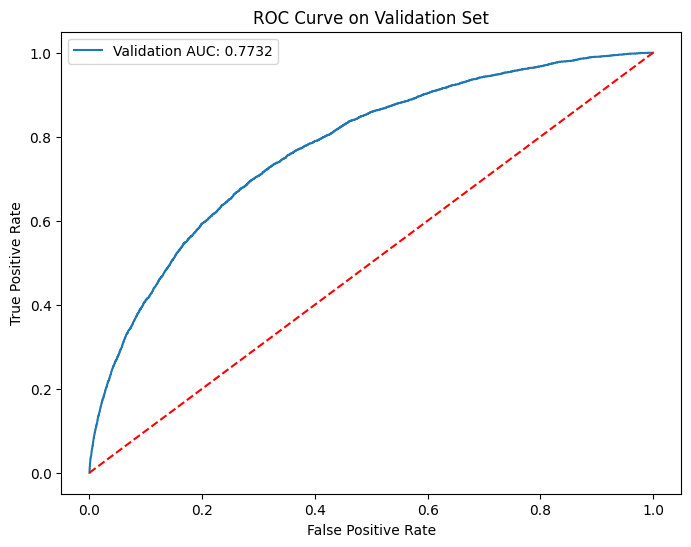

In [12]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define features and target
X = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train['TARGET']

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model with the best parameters found
model = HistGradientBoostingClassifier(
    learning_rate=0.01,
    max_iter=1000,
    max_leaf_nodes=63,
    l2_regularization=1.0,
    random_state=42
)

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the validation set
val_preds = model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, val_preds)

# Print the validation AUC score
print(f"Validation AUC with tuned parameters: {auc_score:.4f}")

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, val_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Validation AUC: {auc_score:.4f}")
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation Set')
plt.legend()
plt.show()

Initial Train shape: (307511, 122)
After one-hot encoding, Train shape: (307511, 262)
After preprocessing, Train shape: (307511, 291)

Training and evaluating HistGradientBoosting...
AUC: 0.7763
Accuracy: 0.9202
Precision: 0.5751
Recall: 0.0317
F1 Score: 0.0601


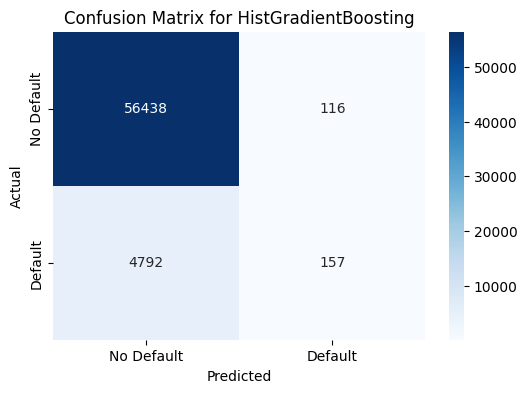


Training and evaluating RandomForest...
AUC: 0.7239
Accuracy: 0.9197
Precision: 0.8333
Recall: 0.0020
F1 Score: 0.0040


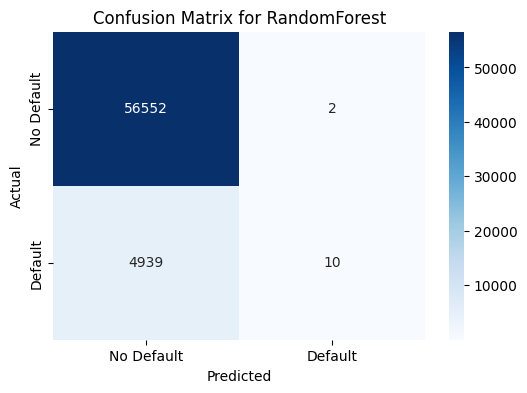

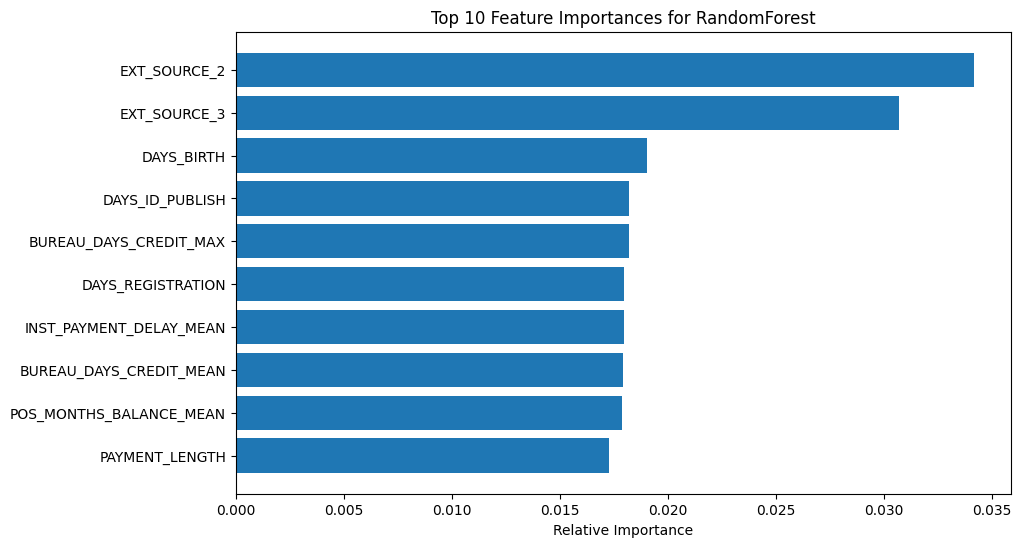


Training and evaluating LogisticRegression...
AUC: 0.7546
Accuracy: 0.9192
Precision: 0.4425
Recall: 0.0156
F1 Score: 0.0301


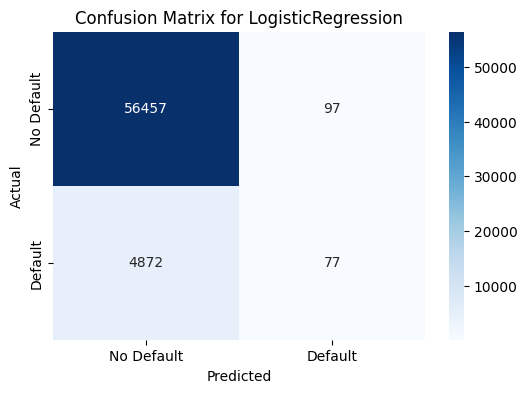

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Load main dataset
train = pd.read_csv("./home-credit-default-risk/application_train.csv")

print("Initial Train shape:", train.shape)

# Identify all categorical columns
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# One-hot encode all categorical columns
train = pd.get_dummies(train, columns=cat_cols, dummy_na=True)

print("After one-hot encoding, Train shape:", train.shape)

# --- Additional Feature Engineering ---

# Loan payment length
train['PAYMENT_LENGTH'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']

# Difference between actual and expected monthly payment
train['PAYMENT_DIFF'] = train['AMT_CREDIT'] - train['AMT_ANNUITY']

# Ratio between credit usage and credit limit
train['CREDIT_LIMIT_RATIO'] = train['AMT_CREDIT'] / (train['AMT_GOODS_PRICE'] + 1e-6)

# --- Bureau and Bureau Balance ---

bureau = pd.read_csv("./home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("./home-credit-default-risk/bureau_balance.csv")

# Aggregate bureau_balance with time-weighted features
bureau_balance['MONTHS_BALANCE_WEIGHT'] = bureau_balance['MONTHS_BALANCE'].apply(lambda x: np.exp(-x / 12))
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'STATUS': ['nunique'],
    'MONTHS_BALANCE_WEIGHT': ['sum']
})
bureau_balance_agg.columns = ['BUREAU_BAL_' + '_'.join(col).upper() for col in bureau_balance_agg.columns]

# Merge bureau_balance aggregates with bureau
bureau = bureau.merge(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
del bureau_balance, bureau_balance_agg
gc.collect()

# Aggregate bureau data by SK_ID_CURR
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'BUREAU_BAL_MONTHS_BALANCE_WEIGHT_SUM': ['sum']
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]

# Merge bureau aggregates with train
train = train.merge(bureau_agg, how='left', on='SK_ID_CURR')
del bureau, bureau_agg
gc.collect()

# --- Previous Applications ---

prev = pd.read_csv("./home-credit-default-risk/previous_application.csv")

# Create new features
prev['APP_CREDIT_DIFF'] = prev['AMT_CREDIT'] - prev['AMT_APPLICATION']
prev['APP_CREDIT_RATIO'] = prev['AMT_CREDIT'] / (prev['AMT_APPLICATION'] + 1e-6)

# Aggregate previous applications
prev_agg = prev.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'max'],
    'AMT_CREDIT': ['mean', 'max'],
    'APP_CREDIT_DIFF': ['mean'],
    'APP_CREDIT_RATIO': ['mean'],
    'NAME_CONTRACT_STATUS': ['nunique']
})
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]

train = train.merge(prev_agg, how='left', on='SK_ID_CURR')
del prev, prev_agg
gc.collect()

# --- POS_CASH_balance ---

pos = pd.read_csv("./home-credit-default-risk/POS_CASH_balance.csv")

# Aggregate POS_CASH_balance
pos_agg = pos.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['max', 'mean'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
})
pos_agg.columns = ['POS_' + '_'.join(col).upper() for col in pos_agg.columns]

train = train.merge(pos_agg, how='left', on='SK_ID_CURR')
del pos, pos_agg
gc.collect()

# --- Installments Payments ---

inst = pd.read_csv("./home-credit-default-risk/installments_payments.csv")

# Aggregate installments payments
inst['PAYMENT_DELAY'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
inst['PAYMENT_RATIO'] = inst['AMT_PAYMENT'] / (inst['AMT_INSTALMENT'] + 1e-6)

inst_agg = inst.groupby('SK_ID_CURR').agg({
    'AMT_INSTALMENT': ['mean', 'sum'],
    'AMT_PAYMENT': ['mean', 'sum'],
    'PAYMENT_DELAY': ['mean', 'max'],
    'PAYMENT_RATIO': ['mean']
})
inst_agg.columns = ['INST_' + '_'.join(col).upper() for col in inst_agg.columns]

train = train.merge(inst_agg, how='left', on='SK_ID_CURR')
del inst, inst_agg
gc.collect()

# --- Final Preprocessing ---

# Fill missing values
train.fillna(train.median(), inplace=True)

# Define features and target
X = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train['TARGET']

# Feature Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("After preprocessing, Train shape:", X.shape)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Model Initialization ---

models = {
    'HistGradientBoosting': HistGradientBoostingClassifier(learning_rate=0.01, max_iter=1000, max_leaf_nodes=63, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# --- Model Training and Evaluation ---

for model_name, model in models.items():
    print(f"\nTraining and evaluating {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Calculate and print metrics
    auc = roc_auc_score(y_val, y_pred_proba)
    acc = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
        # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV] END l2_regularization=0.1, learning_rate=0.01, max_iter=500, max_leaf_nodes=31; total time= 3.8min
[CV] END l2_regularization=0.1, learning_rate=0.01, max_iter=500, max_leaf_nodes=31; total time= 3.8min
[CV] END l2_regularization=0.1, learning_rate=0.1, max_iter=500, max_leaf_nodes=31; total time=  43.0s
[CV] END l2_regularization=0.1, learning_rate=0.1, max_iter=500, max_leaf_nodes=31; total time=  44.1s
[CV] END l2_regularization=0.1, learning_rate=0.01, max_iter=1000, max_leaf_nodes=31; total time= 4.8min
[CV] END l2_regularization=0.1, learning_rate=0.01, max_iter=500, max_leaf_nodes=63; total time= 4.9min
[CV] END l2_regularization=0.1, learning_rate=0.01, max_iter=500, max_leaf_nodes=63; total time= 4.9min
[CV] END l2_regularization=0.1, learning_rate=0.01, max_iter=1000, max_leaf_nodes=63; total time= 5.2min
[CV] END l2_regularization=0.1, learning_rate=0.01, max_iter=1000, max_leaf_nodes=31; total time= 5.3min
[C

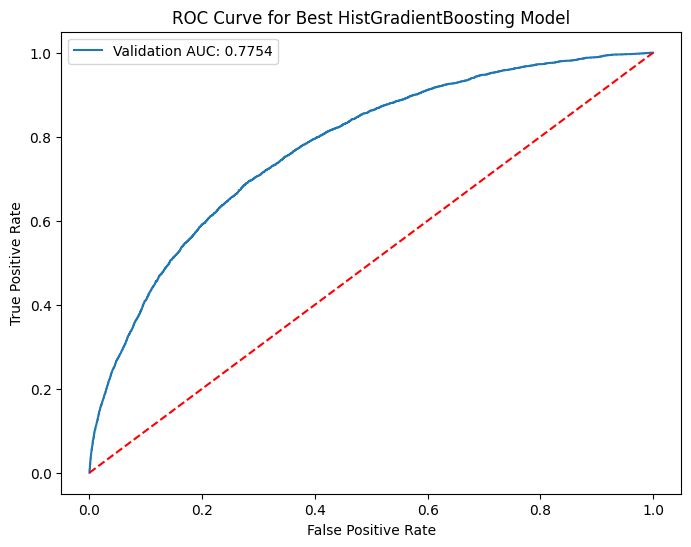

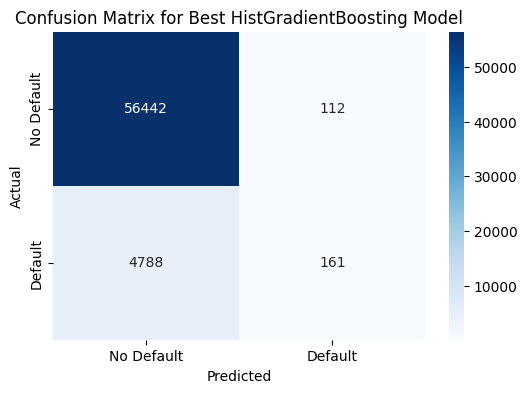

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.59      0.03      0.06      4949

    accuracy                           0.92     61503
   macro avg       0.76      0.52      0.51     61503
weighted avg       0.90      0.92      0.89     61503



In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_iter': [500, 1000],
    'max_leaf_nodes': [31, 63],
    'l2_regularization': [0.1, 1.0]
}

# Initialize the HistGradientBoostingClassifier
hgb = HistGradientBoostingClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(hgb, param_grid, scoring='roc_auc', cv=2, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_hgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Predict on the validation set using the best model
y_pred = best_hgb.predict(X_val)
y_pred_proba = best_hgb.predict_proba(X_val)[:, 1]

# Calculate ROC AUC
auc = roc_auc_score(y_val, y_pred_proba)
print(f"Validation AUC: {auc:.4f}")

# Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Validation AUC: {auc:.4f}")
plt.plot([0, 1], [0, 1], '--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best HistGradientBoosting Model')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Best HistGradientBoosting Model')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))


In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier

# Load main dataset
train = pd.read_csv("./home-credit-default-risk/application_train.csv")

print("Initial Train shape:", train.shape)

# --- Additional Feature Engineering ---

# Replace anomalous values
train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Loan payment length
train['PAYMENT_LENGTH'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']

# Difference between actual and expected monthly payment
train['PAYMENT_DIFF'] = train['AMT_CREDIT'] - train['AMT_ANNUITY']

# Ratio between credit usage and credit limit
train['CREDIT_LIMIT_RATIO'] = train['AMT_CREDIT'] / (train['AMT_GOODS_PRICE'] + 1e-6)

# Aggregated Features based on Combinations of Categorical Columns (before one-hot encoding)
grouped = train.groupby(['CODE_GENDER', 'NAME_EDUCATION_TYPE']).agg({
    'AMT_ANNUITY': 'max',
    'AMT_CREDIT': 'max',
    'OWN_CAR_AGE': 'mean',
    'EXT_SOURCE_1': 'mean',
    'EXT_SOURCE_2': 'mean'
})
grouped.columns = ["_".join(col).upper() for col in grouped.columns]
train = train.merge(grouped, how='left', on=['CODE_GENDER', 'NAME_EDUCATION_TYPE'])

# Identify all categorical columns
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# One-hot encode all categorical columns
train = pd.get_dummies(train, columns=cat_cols, dummy_na=True)

print("After one-hot encoding, Train shape:", train.shape)

# --- Bureau and Bureau Balance ---

bureau = pd.read_csv("./home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("./home-credit-default-risk/bureau_balance.csv")

# Aggregate bureau_balance with time-weighted features
bureau_balance['MONTHS_BALANCE_WEIGHT'] = bureau_balance['MONTHS_BALANCE'].apply(lambda x: np.exp(-x / 12))
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'STATUS': ['nunique'],
    'MONTHS_BALANCE_WEIGHT': ['sum']
})
bureau_balance_agg.columns = ['BUREAU_BAL_' + '_'.join(col).upper() for col in bureau_balance_agg.columns]

# Merge bureau_balance aggregates with bureau
bureau = bureau.merge(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
del bureau_balance, bureau_balance_agg
gc.collect()

# Aggregate bureau data by SK_ID_CURR
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'BUREAU_BAL_MONTHS_BALANCE_WEIGHT_SUM': ['sum']
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]

# Merge bureau aggregates with train
train = train.merge(bureau_agg, how='left', on='SK_ID_CURR')
del bureau, bureau_agg
gc.collect()

# --- Previous Applications ---

prev = pd.read_csv("./home-credit-default-risk/previous_application.csv")

# Create new features
prev['APP_CREDIT_DIFF'] = prev['AMT_CREDIT'] - prev['AMT_APPLICATION']
prev['APP_CREDIT_RATIO'] = prev['AMT_CREDIT'] / (prev['AMT_APPLICATION'] + 1e-6)

# Aggregate previous applications
prev_agg = prev.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'max'],
    'AMT_CREDIT': ['mean', 'max'],
    'APP_CREDIT_DIFF': ['mean'],
    'APP_CREDIT_RATIO': ['mean'],
    'NAME_CONTRACT_STATUS': ['nunique']
})
prev_agg.columns = ['PREV_' + '_'.join(col).upper() for col in prev_agg.columns]

train = train.merge(prev_agg, how='left', on='SK_ID_CURR')
del prev, prev_agg
gc.collect()

# --- Final Preprocessing ---

# Fill missing values
train.fillna(train.median(), inplace=True)

print("After merging all aggregates, Train shape:", train.shape)

# --- Modeling with Stratified K-Fold Cross-Validation ---

# Define features and target
X = train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train['TARGET']

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Initialize the model
    model = HistGradientBoostingClassifier(
        learning_rate=0.01,
        max_iter=1000,
        max_leaf_nodes=63,
        l2_regularization=1.0,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    val_preds = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, val_preds)
    auc_scores.append(auc_score)
    
    print(f"Fold AUC: {auc_score:.4f}")

# Print the average AUC score
print(f"Average AUC: {np.mean(auc_scores):.4f}")

Initial Train shape: (307511, 122)


/var/folders/my/5pbqkp817313j1bx7jlmbynr0000gn/T/ipykernel_25771/3829510481.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


After one-hot encoding, Train shape: (307511, 270)
After merging all aggregates, Train shape: (307511, 285)
Fold AUC: 0.7663
Fold AUC: 0.7753
Fold AUC: 0.7681
Fold AUC: 0.7724
Fold AUC: 0.7633
Average AUC: 0.7691


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier

# Load main dataset
train = pd.read_csv("./home-credit-default-risk/application_train.csv")

print("Initial Train shape:", train.shape)

# --- Additional Feature Engineering ---

# Replace anomalous values
train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Loan payment length
train['PAYMENT_LENGTH'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']

# Difference between actual and expected monthly payment
train['PAYMENT_DIFF'] = train['AMT_CREDIT'] - train['AMT_ANNUITY']

# Ratio between credit usage and credit limit
train['CREDIT_LIMIT_RATIO'] = train['AMT_CREDIT'] / (train['AMT_GOODS_PRICE'] + 1e-6)

# Aggregated Features based on Combinations of Categorical Columns (before one-hot encoding)
grouped = train.groupby(['CODE_GENDER', 'NAME_EDUCATION_TYPE']).agg({
    'AMT_ANNUITY': 'max',
    'AMT_CREDIT': 'max',
    'OWN_CAR_AGE': 'mean',
    'EXT_SOURCE_1': 'mean',
    'EXT_SOURCE_2': 'mean'
})
grouped.columns = ["_".join(col).upper() for col in grouped.columns]
train = train.merge(grouped, how='left', on=['CODE_GENDER', 'NAME_EDUCATION_TYPE'])

# Identify all categorical columns
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# One-hot encode all categorical columns
train = pd.get_dummies(train, columns=cat_cols, dummy_na=True)

print("After one-hot encoding, Train shape:", train.shape)

# --- Bureau and Bureau Balance ---

bureau = pd.read_csv("./home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("./home-credit-default-risk/bureau_balance.csv")

# Aggregate bureau_balance with time-weighted features
bureau_balance['MONTHS_BALANCE_WEIGHT'] = bureau_balance['MONTHS_BALANCE'].apply(lambda x: np.exp(-x / 12))
bureau_balance_agg = bureau_balance.groupby('SK_ID_BUREAU').agg({
    'MONTHS_BALANCE': ['min', 'max', 'mean'],
    'STATUS': ['nunique'],
    'MONTHS_BALANCE_WEIGHT': ['sum']
})
bureau_balance_agg.columns = ['BUREAU_BAL_' + '_'.join(col).upper() for col in bureau_balance_agg.columns]

# Merge bureau_balance aggregates with bureau
bureau = bureau.merge(bureau_balance_agg, how='left', on='SK_ID_BUREAU')
del bureau_balance, bureau_balance_agg
gc.collect()

# Aggregate bureau data by SK_ID_CURR
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'DAYS_CREDIT': ['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['mean', 'sum'],
    'BUREAU_BAL_MONTHS_BALANCE_WEIGHT_SUM': ['sum']
})
bureau_agg.columns = ['BUREAU_' + '_'.join(col).upper() for col in bureau_agg.columns]

# Merge bureau aggregates with train
train = train.merge(bureau_agg, how='left', on='SK_ID_CURR')
del bureau, bureau_agg
gc.collect()

# --- Final Preprocessing ---

# Fill missing values
train.fillna(train.median(), inplace=True)

# Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(train.drop(['TARGET', 'SK_ID_CURR'], axis=1))
X = pd.DataFrame(scaled_features, columns=train.drop(['TARGET', 'SK_ID_CURR'], axis=1).columns)
y = train['TARGET']

print("After merging all aggregates, Train shape:", X.shape)

# --- Modeling with HistGradientBoostingClassifier and Stratified K-Fold Cross-Validation ---

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Initialize the HistGradientBoostingClassifier model
    model = HistGradientBoostingClassifier(
        learning_rate=0.01,
        max_iter=1000,
        max_leaf_nodes=63,
        l2_regularization=1.0,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the validation set
    val_preds = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, val_preds)
    auc_scores.append(auc_score)
    
    print(f"Fold AUC: {auc_score:.4f}")

# Print the average AUC score
print(f"Average AUC: {np.mean(auc_scores):.4f}")


Initial Train shape: (307511, 122)


/var/folders/my/5pbqkp817313j1bx7jlmbynr0000gn/T/ipykernel_32151/1433752193.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


After one-hot encoding, Train shape: (307511, 270)
After merging all aggregates, Train shape: (307511, 276)
Fold AUC: 0.7637
Fold AUC: 0.7735
Fold AUC: 0.7658
Fold AUC: 0.7703
Fold AUC: 0.7616
Average AUC: 0.7670


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'l2_regularization': 1.0, 'learning_rate': 0.01, 'max_iter': 1000, 'max_leaf_nodes': 63}
Best CV AUC: 0.7677651351974669
Validation AUC with tuned parameters: 0.7722455790942637


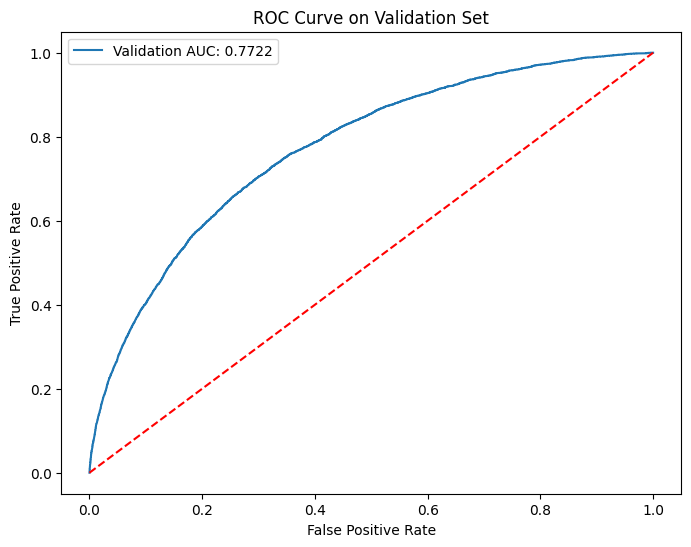

In [14]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter': [200, 500, 1000],
    'max_leaf_nodes': [31, 63, 127],
    'l2_regularization': [0.0, 0.1, 1.0]
}

model = HistGradientBoostingClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', 
                           cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

# Train the final model with best parameters
best_model = grid_search.best_estimator_
val_preds = best_model.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, val_preds)
print("Validation AUC with tuned parameters:", auc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_val, val_preds)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"Validation AUC: {auc_score:.4f}")
plt.plot([0,1],[0,1],'--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Validation Set')
plt.legend()
plt.show()


In [ ]:
# Predict on test set
test_preds = model.predict_proba(X_test)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_preds})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")